## Imports

In [78]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None)

import math
import scipy
import time
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [79]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.2.0'

In [80]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Google Drive path
path = '/content/drive/My Drive/NYCDSA/lending_club/'  

Mounted at /content/drive


## Load X,Y

In [116]:
tic = time.time()

test_mode = 'recent'
timestamp = '1593052237' #1592571747

X_train = pd.read_csv(path+f'features/X_train_{test_mode}_{timestamp}.csv')
X_test = pd.read_csv(path+f'features/X_test_{test_mode}_{timestamp}.csv')
Y_train = pd.read_csv(path+f'features/Y_train_{test_mode}_{timestamp}.csv')
Y_test = pd.read_csv(path+f'features/Y_test_{test_mode}_{timestamp}.csv')    

X_train.set_index('id', inplace=True)
X_test.set_index('id', inplace=True)
Y_train.set_index('id', inplace=True)
Y_test.set_index('id', inplace=True)

Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)

print(f'Loaded in {time.time()-tic:.2f}')

Loaded in 4.37


Input data: X,Y train/val/test dataframes

HP / input parameters:
- all subgrades / indicate subgrade
- all features / indicate feature
- models: nn / logistic / XGBoost

Cycle:
- produce new X,Y train/val/test dataframes
- normalize, truncate
- call Function
- add metrics to report_df

Function:
1.   train model
2.   predict Y_train_hat, Y_test_hat 
3.   produce metrics
4.   optional: plot roc, precision graph
5.   return metrics 




## Helper Functions

In [117]:
def normalize_arrays(fit_arr, *arrs):
    scaler = StandardScaler()
    fit_arr = scaler.fit_transform(fit_arr)
    out=[]
    for arr in arrs:
        out.append(scaler.transform(arr))
    return [fit_arr]+out

def truncate_outliers(*arrs, sd_max=5):
    out = []
    for arr in arrs:
        out.append(np.clip(arr, -sd_max, sd_max))
    return out


In [118]:
def save_predictions(Y_test, Y_test_hat, test_mode):
    
    timestamp = int(time.time())
    filename = f'predictions_{test_mode}_{timestamp}.csv'
    
    Y_test_hat = pd.Series(np.squeeze(Y_test_hat), name='p', index=Y_test.index)
    predictions=pd.concat([Y_test, Y_test_hat], axis=1)
    predictions.to_csv(path+'features/'+filename)
    
    print(f'saved: {filename}')

In [119]:
def save_report(df_report, test_mode):
    
    timestamp = int(time.time())
    filename = f'report_{test_mode}_{timestamp}.csv'
    
    df_report.to_csv(path+'reports/'+filename)
    
    print(f'saved: {filename}')

In [120]:
def plot_roc(Y_train_hat, Y_test_hat, Y_train, Y_test, model_name):

    AUC_train = roc_auc_score(Y_train, Y_train_hat)
    AUC_test = roc_auc_score(Y_test, Y_test_hat)

    fp_train, tp_train, _ = roc_curve(Y_train, Y_train_hat)
    fp_test, tp_test, thresholds = roc_curve(Y_test, Y_test_hat)

    precision = 1/(1+ (1/np.mean(Y_test)-1)*(fp_test/tp_test))
    thresholds[0]=1  #sklearn may produce arbitrary first threshold > 1

    ref_thresholds = np.linspace(min(thresholds), max(thresholds),1000)
    selected = [np.nanmean(Y_test_hat>p) for p in ref_thresholds]

    _,axes = plt.subplots(1, 2, figsize=(14, 6))
    ax0,ax1=axes[0],axes[1]

    ax0.plot(fp_train, tp_train, label=f'Train. AUC={AUC_train:.4f}')
    ax0.plot(fp_test, tp_test, label=f'Test. AUC={AUC_test:.4f}')
    ax0.plot((0,1),(0,1), color='grey')
    ax0.plot((np.mean(Y_train)), (np.mean(Y_train)), color='grey', marker='o', label='random')
    ax0.set_xlabel('false positive rate')
    ax0.set_ylabel('recall')
    ax0.set_title(f'ROC: {model_name}')
    ax0.legend(loc='lower right')
    ax0.grid(True)

    ax1.plot(thresholds, precision, label=f'precision')
    ax1.plot(ref_thresholds, selected, label=f'selected %')
    ax1.set_xlabel('cutoff thresholds')
    ax1.set_title(f'Precision and selected %')
    ax1.legend(loc='lower right')
    ax1.invert_xaxis()
    ax1.grid(True)

    plt.show()

In [121]:
def plot_report_metrics(df_report, test_mode):
    fig,axes = plt.subplots(1, 2, figsize=(14, 5))
    ax0,ax1=axes[0],axes[1]
    model_name = df_report.model[0]

    for col in ['prec_5','prec_10','prec_20','support']:
        ax0.plot(df_report.run, df_report[col]/df_report['support'], label=col)
    ax0.set_title(f'{test_mode} OOS   {model_name}   Lift')
    ax0.set_ylabel('lift')
    ax0.legend()

    for col in ['support','AUC_test']:
        ax1.plot(df_report.run, df_report[col], label=col)
    ax1.set_title(f'{test_mode} OOS   {model_name}   AUC')
    ax1.legend()

    plt.show()


## Training & Prediction

In [87]:
def model_train(X_train, X_val, Y_train, Y_val, model_name, **kwargs):
    
    verbose = 0 if 'verbose' not in kwargs.keys() else kwargs['verbose']

    # 1. NEURAL NETWORK ========================
    if 'neural' in model_name:
        neg, pos = np.bincount(Y_train)
        EPOCHS = 40
        BATCH_SIZE = 1024

        # small fully connected, anything more powerful overfits
        model = keras.Sequential([
            keras.layers.Dense(256, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.001),
                            input_shape=(X_train.shape[-1],)),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation='sigmoid',
                            bias_initializer=tf.keras.initializers.Constant(np.log(pos/neg))),
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(lr=1e-4),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=[keras.metrics.Precision(name='precision'), 
                     keras.metrics.Recall(name='recall'), 
                     keras.metrics.AUC(name='auc'),])
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
            patience=5, mode='max', restore_best_weights=True)
        
        history = model.fit(
            X_train,
            Y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=verbose,
            callbacks = [early_stopping],
            validation_data=(X_val, Y_val))
        
    # 2. LOGISTIC REGRESSION ========================
    if 'logistic' in model_name:
        model = LogisticRegression(penalty='l1', 
                                   C=100, 
                                   verbose=verbose,
                                   solver='liblinear') # best HP from BD18
        model.fit(X_train, Y_train)

    # 3. XGBoost ========================
    if 'xgboost' in model_name:
        model= XGBClassifier(base_score=0.8, 
                            colsample_bylevel=0.5,   #<<<<<
                            colsample_bytree=0.5,  #<<<<<
                            gamma=0, 
                            learning_rate=1,  #<<<<<
                            max_depth=3, 
                            min_child_weight=0, 
                            n_estimators=2000,   #<<<<< 
                            nthread=-1, 
                            objective='binary:logistic',
                            reg_alpha=0.5, 
                            reg_lambda=1, 
                            seed=0, silent=False,
                            subsample=0.5)
        model.fit(X_train, Y_train)
    return model


In [88]:
def predict_probs(X_train, X_test, Y_train, Y_test,
                   model_name,
                   select_top=[0.05, 0.1, 0.2],
                   show_plot=True,
                   **kwargs
                   ):
    """Implement the cycle of training, predicting, and producing basic metrics
    Args:   X,Y  split into  train/val/test 
            model name
            hyperparameters
    Returns: arrays with Y_test {1:good,0:default) and Y_test_hat (probabilities)
             AUC_train, AUC_test
             precision and support metric for selected % of loans (HP select_top)
    """
    # 1. Split 5% validation, Normalize
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.05)
    X_train, X_val, X_test = normalize_arrays(X_train, X_val, X_test)
    X_train, X_val, X_test = truncate_outliers(X_train, X_val, X_test)

    # 2. train model
    verbose = 0 if 'verbose' not in kwargs.keys() else kwargs['verbose']
    tic = time.time()
    model = model_train(X_train, X_val, Y_train, Y_val, model_name, verbose=verbose)
    print(f'model trained in {time.time()-tic:.1f}sec')        

    # 3. predict Y_train_hat, Y_test_hat
    if 'neural' in model_name:
        Y_train_hat = model.predict(X_train)
        Y_test_hat = model.predict(X_test)
    else:
        Y_train_hat = model.predict_proba(X_train)[:,1]
        Y_test_hat = model.predict_proba(X_test)[:,1]

    # 4. Produce metrics
    AUC_train = roc_auc_score(Y_train, Y_train_hat)
    AUC_test = roc_auc_score(Y_test, Y_test_hat)
    fp_test, tp_test, thresholds = roc_curve(Y_test, Y_test_hat)

    support = np.nanmean(Y_test)
    indices = np.searchsorted(thresholds[::-1], np.quantile(Y_test_hat, 1-np.array(select_top)))
    precision = 1/(1 + (fp_test[-indices]/tp_test[-indices])*(1/support-1))
    precision = {k:v for k,v in zip(select_top, precision)}
    precision.update({1:support})

    # 5. Optional: plot roc, precision graph
    if show_plot:
        plot_roc(Y_train_hat, Y_test_hat, Y_train, Y_test, model_name)
    
    print(f'{AUC_train:.5f} {AUC_test:.5f} \n{precision}')
    
    # include Y_test in the output for verification purposes (Y_test<-->Y_test_hat)
    return Y_test, Y_test_hat, AUC_train, AUC_test, precision

## All Loans classification

#### Neural Network

model trained in 158.9sec


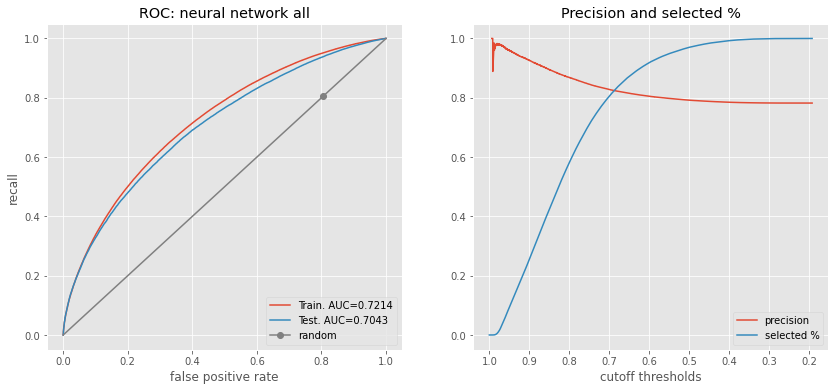

0.72142 0.70434 
{0.05: 0.9718038139051719, 0.1: 0.9584820101100208, 0.2: 0.9363710696498921, 1: 0.7821463088246227}


In [129]:
Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
    predict_probs(X_train, X_test, Y_train, Y_test, 
                'neural network all', 
                show_plot=True, 
                verbose=0)

# save_predictions(Y_test, Y_test_hat, test_mode)

#### Logistic Regression

model trained in 343.3sec


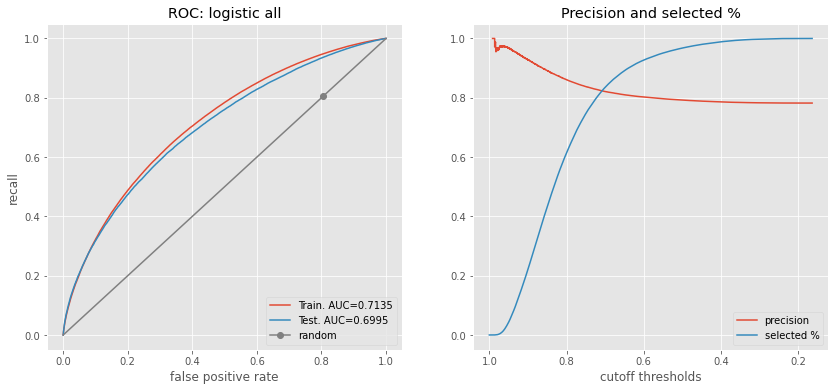

0.71345 0.69951 
{0.05: 0.9657350973688122, 0.1: 0.9535738142952572, 0.2: 0.9322282719788898, 1: 0.7821463088246227}


In [101]:
Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
    predict_probs(X_train, X_test, Y_train, Y_test, 
                'logistic all', 
                show_plot=True, 
                verbose=0)

# save_predictions(Y_test, Y_test_hat, test_mode)

#### XGBoost Classifier

model trained in 551.6sec


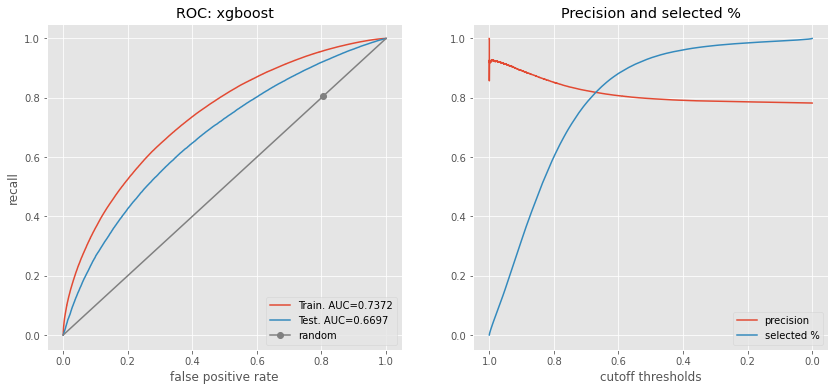

0.73720 0.66965 
{0.05: 0.9248030910982316, 0.1: 0.9205216809720209, 0.2: 0.9082461389781998, 1: 0.7821463088246227}


In [71]:
Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
    predict_probs(X_train, X_test, Y_train, Y_test, 
                'xgboost', 
                show_plot=True, 
                verbose=0)

# save_predictions(Y_test, Y_test_hat, test_mode)   

## NN Sequential Retraining

In [72]:
# a general report dataframe structure:
df_template = pd.DataFrame(columns=['model',
                                  'test_year',
                                  'sec',
                                  'n_loans',
                                  'AUC_test',
                                  'prec_5',
                                  'prec_10',
                                  'prec_20',
                                  'support',
                                  'lift_5',
                                  'lift_10',
                          
                                  'lift_20',
                                  ])
df_template

,model,test_year,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20


In [73]:
df['issue_year'] = df.issue_d.apply(lambda x: x.year)

predictions = pd.DataFrame(columns=['_good','p'])
model_name = 'neural_256'
df_report = df_template.copy()


timestamp = int(time.time())
X.to_csv(path+f'sequential/X_full_{timestamp}.csv')
Y.to_csv(path+f'sequential/Y_full_{timestamp}.csv')

for test_year in range(2010, 2019):

    tic = time.time()

    train_indices = df[df.issue_year<test_year].index
    test_indices = df[df.issue_year==test_year].index

    X_train_seq = X.loc[train_indices]
    Y_train_seq = Y.loc[train_indices]

    X_test_seq = X.loc[test_indices]
    Y_test_seq = Y.loc[test_indices]

    Y_test_seq, Y_test_hat_seq, AUC_train, AUC_test, precision =\
        predict_probs(X_train_seq, X_test_seq, Y_train_seq, Y_test_seq,
                    model_name, 
                    show_plot=False, 
                    verbose=0)

    Y_test_hat_seq = pd.Series(np.squeeze(Y_test_hat_seq), name='p', index=Y_test_seq.index)
    predictions_seq = pd.concat([Y_test_seq, Y_test_hat_seq], axis=1)
    predictions = pd.concat([predictions, predictions_seq], axis=0)

    df_report.loc[df_report.shape[0]] = ([model_name] +
                                         [test_year] +
                                         [f'{time.time()-tic:.1f}'] + 
                                         [f'{len(Y_test_hat_seq):,}'] +
                                         [np.round(AUC_test, 4)] +
                                         [np.round(x,4) for x in precision.values()] + 
                            [np.round(x/precision[1],4) for x in list(precision.values())[:-1]] 
                                        )
    print(f'{test_year} completed: \t{time.time()-tic:.1f} sec')
    print('='*60)

predictions.index.rename('id', inplace=True)
predictions.to_csv(path+f'sequential/Y_predictions_{timestamp}.csv')
predictions.shape
predictions.head()

model trained in 4.1sec
0.66559 0.64875 
{0.05: 0.9683544303797468, 0.1: 0.9515625, 0.2: 0.9394422310756972, 1: 0.8598548297040759}
2010 completed: 	4.7 sec
model trained in 4.0sec
0.68799 0.69262 
{0.05: 0.9754098360655739, 0.1: 0.9614325068870524, 0.2: 0.9517684887459807, 1: 0.8482114083145343}
2011 completed: 	5.0 sec
model trained in 9.1sec
0.71132 0.67393 
{0.05: 0.9655688622754491, 0.1: 0.9547578986726492, 0.2: 0.9380796252927401, 1: 0.8380272453014035}
2012 completed: 	11.3 sec
model trained in 16.5sec
0.69699 0.68461 
{0.05: 0.9675843694493784, 0.1: 0.9601717500740301, 0.2: 0.947079547561654, 1: 0.8440402361947716}
2013 completed: 	21.7 sec
model trained in 37.0sec
0.69602 0.70784 
{0.05: 0.9706910459801021, 0.1: 0.9609178917174613, 0.2: 0.9439962350410112, 1: 0.8155022568051528}
2014 completed: 	47.4 sec
model trained in 51.0sec
0.70638 0.73218 
{0.05: 0.975398051014431, 0.1: 0.9644045685684619, 0.2: 0.9482513013725987, 1: 0.7981493562688892}
2015 completed: 	70.6 sec
model tr

,_good,p
id,,
472516,1,0.887166
472531,1,0.902097
471556,1,0.921670
471174,1,0.952609
472631,1,0.849509


In [74]:
predictions.shape

(1339819, 2)

In [75]:
df_report

,model,test_year,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20
0,neural_256,2010,4.7,"12,537",0.6487,0.9684,0.9516,0.9394,0.8599,1.1262,1.1067,1.0926
1,neural_256,2011,5.0,"21,721",0.6926,0.9754,0.9614,0.9518,0.8482,1.1500,1.1335,1.1221
2,neural_256,2012,11.3,"53,367",0.6739,0.9656,0.9548,0.9381,0.8380,1.1522,1.1393,1.1194
3,neural_256,2013,21.7,"134,804",0.6846,0.9676,0.9602,0.9471,0.8440,1.1464,1.1376,1.1221
4,neural_256,2014,47.4,"223,103",0.7078,0.9707,0.9609,0.9440,0.8155,1.1903,1.1783,1.1576
5,neural_256,2015,70.6,"375,545",0.7322,0.9754,0.9644,0.9483,0.7981,1.2221,1.2083,1.1881
6,neural_256,2016,118.7,"293,103",0.7111,0.9671,0.9546,0.9314,0.7671,1.2606,1.2443,1.2141
7,neural_256,2017,194.2,"169,321",0.7083,0.9713,0.9576,0.9326,0.7687,1.2636,1.2458,1.2133
8,neural_256,2018,182.2,"56,318",0.7121,0.9805,0.9740,0.9603,0.8424,1.1639,1.1562,1.1399


## NN Feature Importance

model trained in 4.9sec


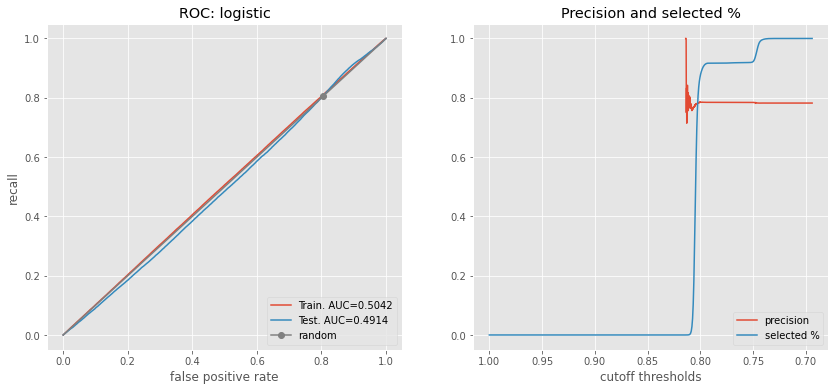

0.50423 0.49139 
{0.05: 0.7622445187662579, 0.1: 0.7649332788164888, 0.2: 0.7691478487129448, 1: 0.7821463088246227}
application_type 	10 sec
model trained in 10.1sec


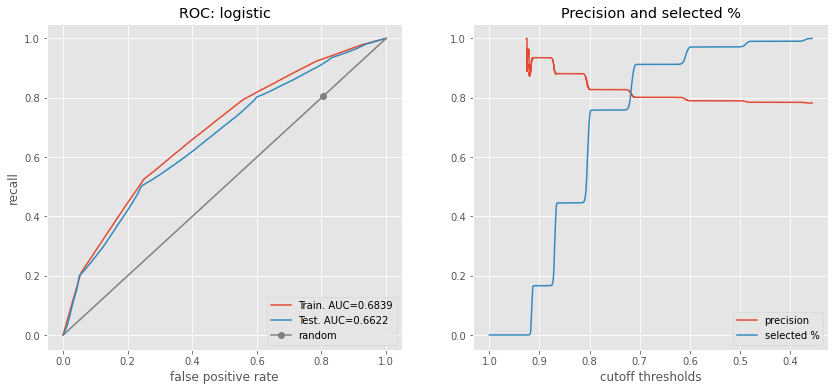

0.68391 0.66223 
{0.05: 0.9177817424918228, 0.1: 0.9287227321713925, 0.2: 0.915610481323174, 1: 0.7821463088246227}
grade 	25 sec
model trained in 8.0sec


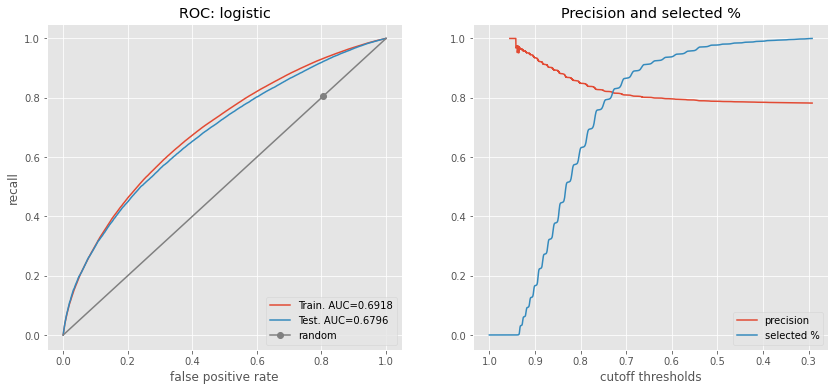

0.69183 0.67958 
{0.05: 0.9605468459766698, 0.1: 0.9495486124010848, 0.2: 0.9261860957796733, 1: 0.7821463088246227}
sub_grade 	38 sec
model trained in 8.0sec


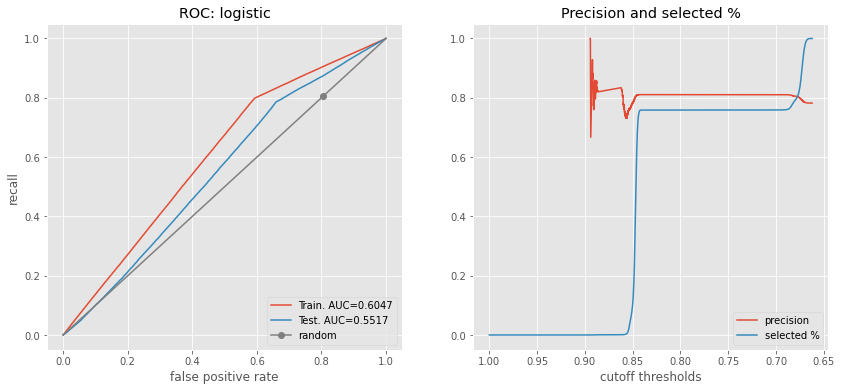

0.60469 0.55165 
{0.05: 0.7653311529026983, 0.1: 0.7826507098788374, 0.2: 0.7918037357122943, 1: 0.7821463088246227}
term 	52 sec
model trained in 4.7sec


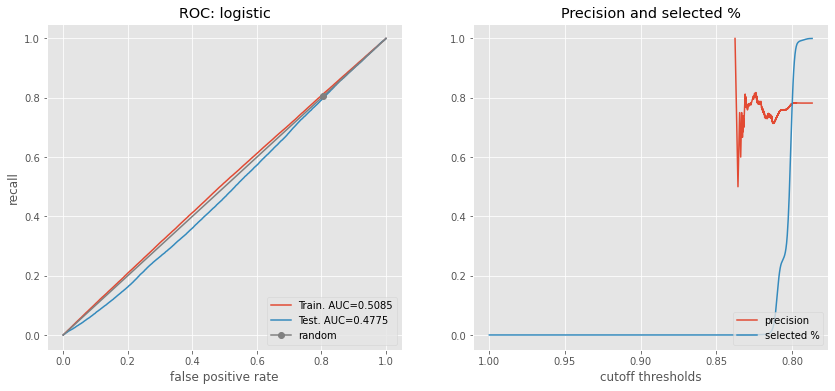

0.50851 0.47746 
{0.05: 0.7194469223907225, 0.1: 0.7324833661673419, 0.2: 0.75097109934021, 1: 0.7821463088246227}
initial_list_status 	61 sec
model trained in 4.7sec


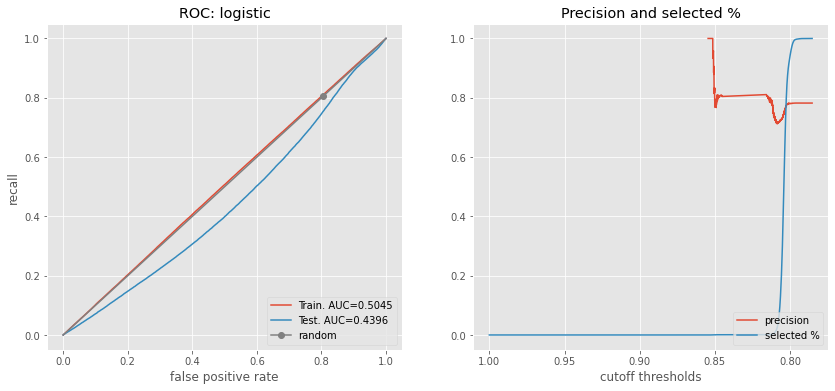

0.50449 0.43963 
{0.05: 0.7178096441043168, 0.1: 0.7212785727559933, 0.2: 0.7267726047765077, 1: 0.7821463088246227}
emp_length 	71 sec
model trained in 6.8sec


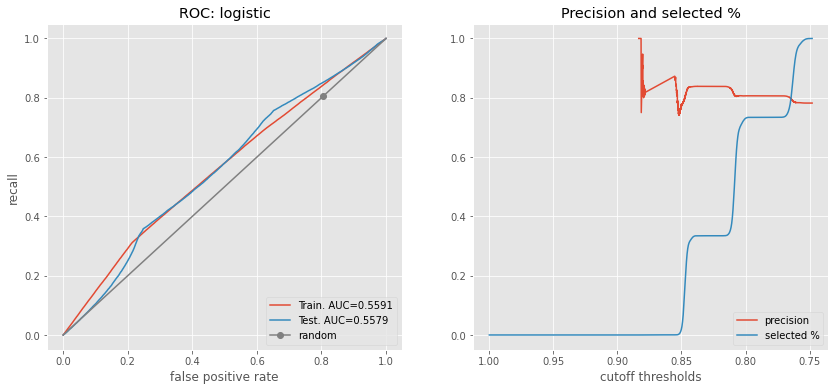

0.55907 0.55792 
{0.05: 0.7818168302111209, 0.1: 0.7902092703415976, 0.2: 0.8093760451893418, 1: 0.7821463088246227}
verification_status 	83 sec
model trained in 8.9sec


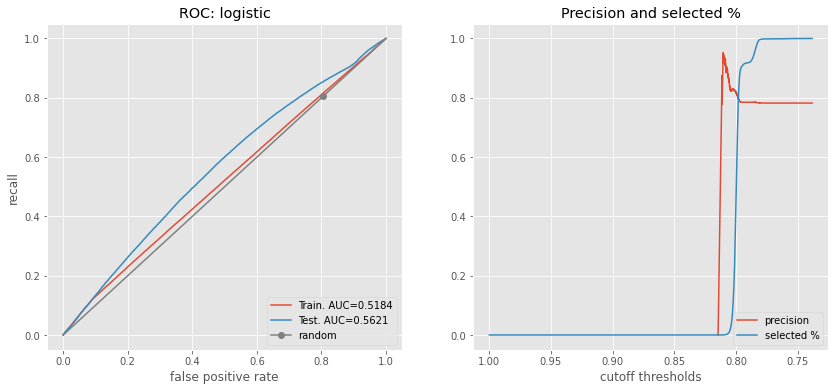

0.51837 0.56209 
{0.05: 0.8254050839898914, 0.1: 0.8271196520834107, 0.2: 0.8261871573273859, 1: 0.7821463088246227}
_has_desc 	97 sec
model trained in 6.0sec


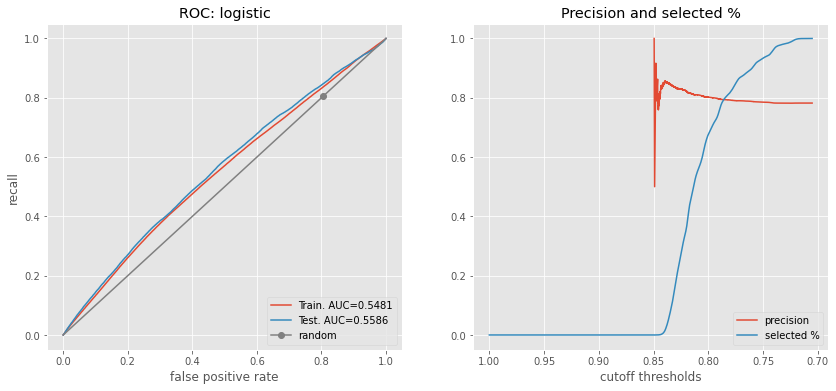

0.54810 0.55864 
{0.05: 0.8486289663372222, 0.1: 0.8417942619295378, 0.2: 0.8314412589881273, 1: 0.7821463088246227}
loan_amnt 	108 sec
model trained in 7.6sec


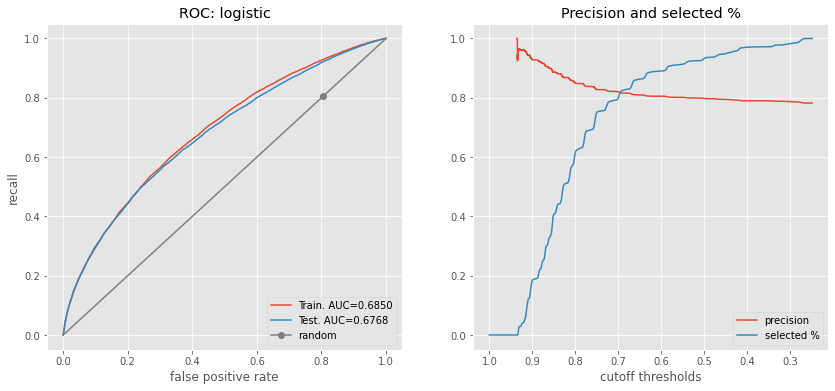

0.68500 0.67675 
{0.05: 0.9589682598676875, 0.1: 0.9472689542725857, 0.2: 0.9245980856797694, 1: 0.7821463088246227}
int_rate 	121 sec
model trained in 8.5sec


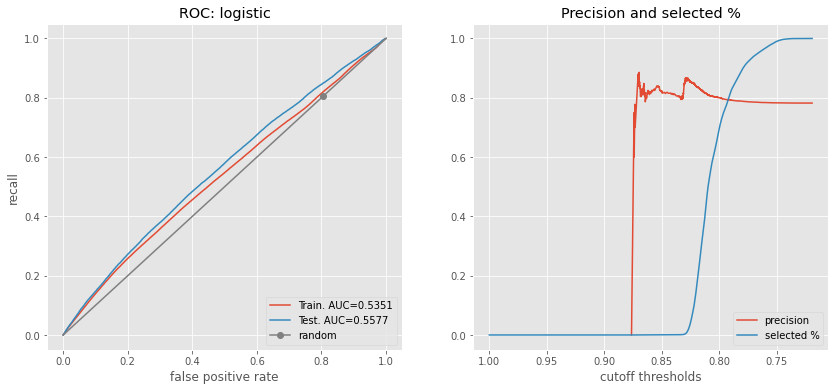

0.53514 0.55771 
{0.05: 0.8527270025263785, 0.1: 0.8481751282241878, 0.2: 0.8351299111623239, 1: 0.7821463088246227}
installment 	134 sec
model trained in 12.2sec


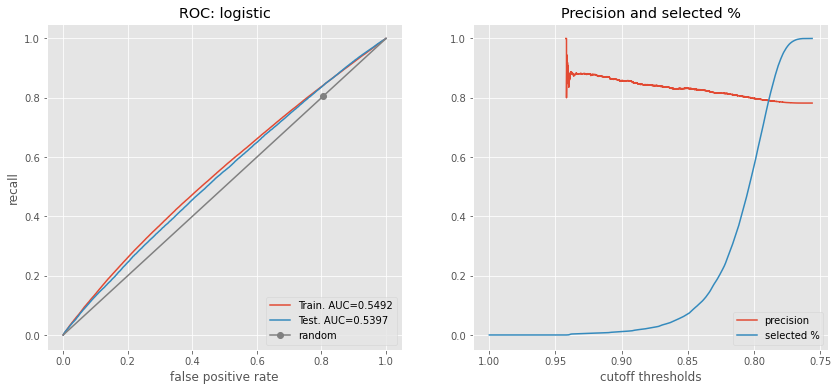

0.54920 0.53971 
{0.05: 0.8296417422327932, 0.1: 0.8271517764233686, 0.2: 0.8158907164761638, 1: 0.7821463088246227}
annual_inc 	151 sec
model trained in 4.7sec


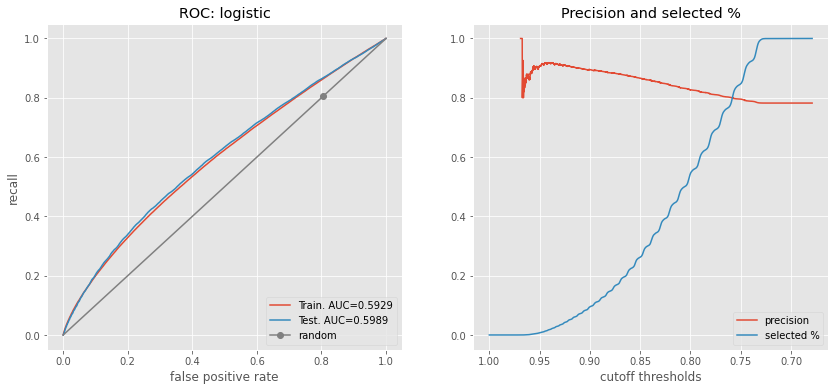

0.59289 0.59889 
{0.05: 0.9067191913185669, 0.1: 0.892080716488907, 0.2: 0.8758219712449381, 1: 0.7821463088246227}
fico_range_low 	161 sec
model trained in 4.1sec


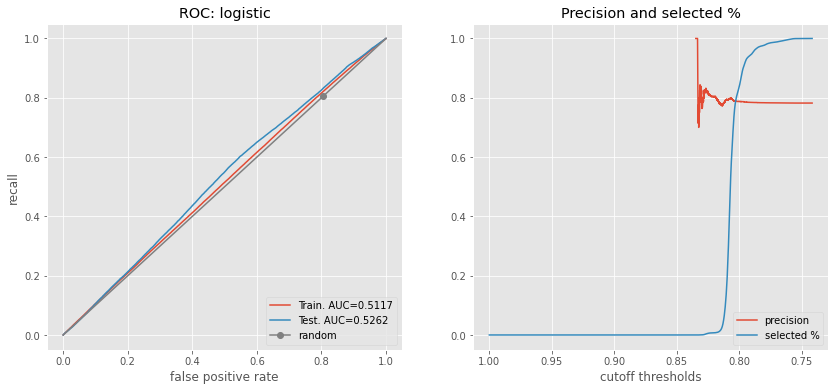

0.51168 0.52621 
{0.05: 0.7820627136275821, 0.1: 0.7907746060065417, 0.2: 0.7928150612373855, 1: 0.7821463088246227}
delinq_2yrs 	170 sec
model trained in 15.6sec


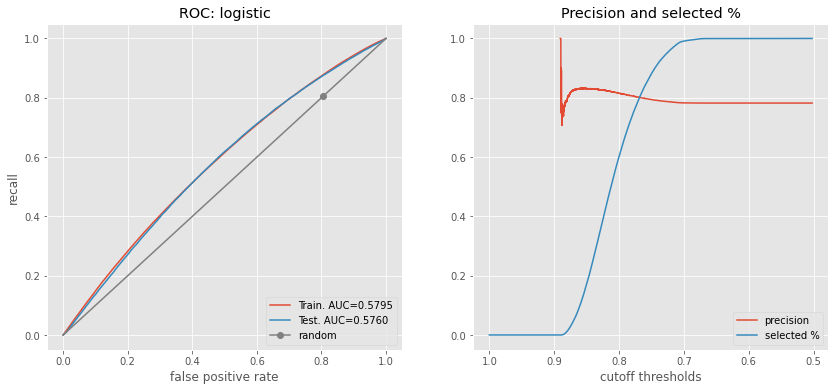

0.57952 0.57605 
{0.05: 0.8261968480523342, 0.1: 0.8303163215998215, 0.2: 0.8301458972214478, 1: 0.7821463088246227}
dti 	191 sec
model trained in 4.4sec


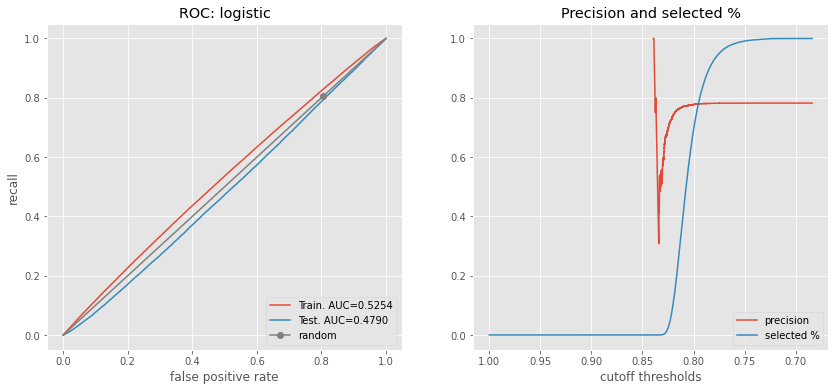

0.52543 0.47900 
{0.05: 0.7190844233055886, 0.1: 0.7398156407969075, 0.2: 0.7576433416968683, 1: 0.7821463088246227}
open_acc 	200 sec
model trained in 4.9sec


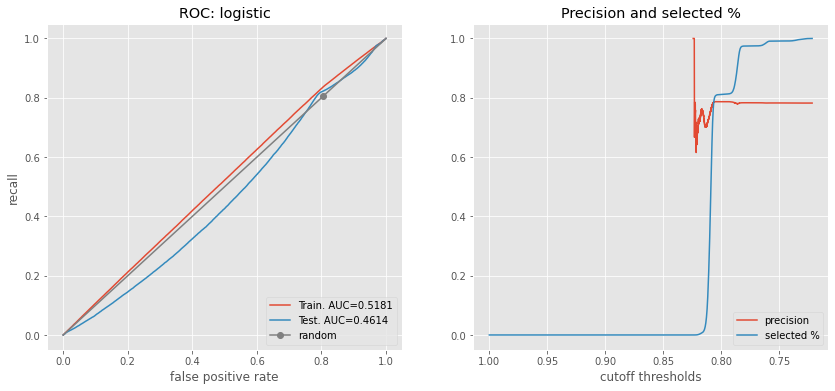

0.51808 0.46136 
{0.05: 0.7045623421013524, 0.1: 0.7141211017358658, 0.2: 0.7284081405073878, 1: 0.7821463088246227}
pub_rec 	210 sec
model trained in 6.8sec


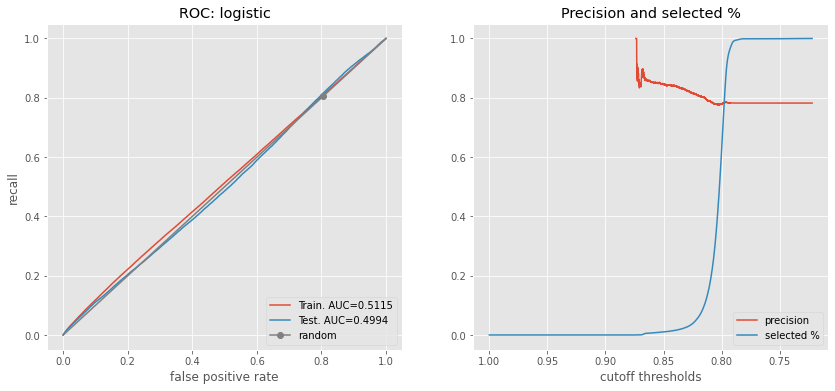

0.51154 0.49939 
{0.05: 0.8117891920017839, 0.1: 0.8007953320697216, 0.2: 0.7855390790500613, 1: 0.7821463088246227}
revol_bal 	222 sec
model trained in 14.0sec


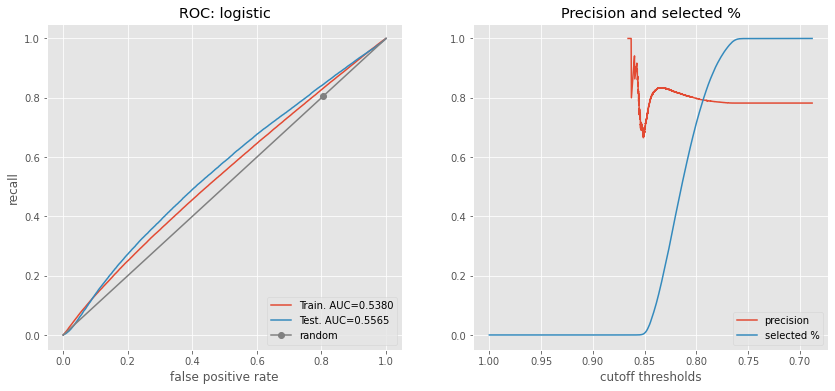

0.53796 0.55653 
{0.05: 0.8021553325901152, 0.1: 0.8264892786799956, 0.2: 0.8331567698169315, 1: 0.7821463088246227}
revol_util 	241 sec
model trained in 6.8sec


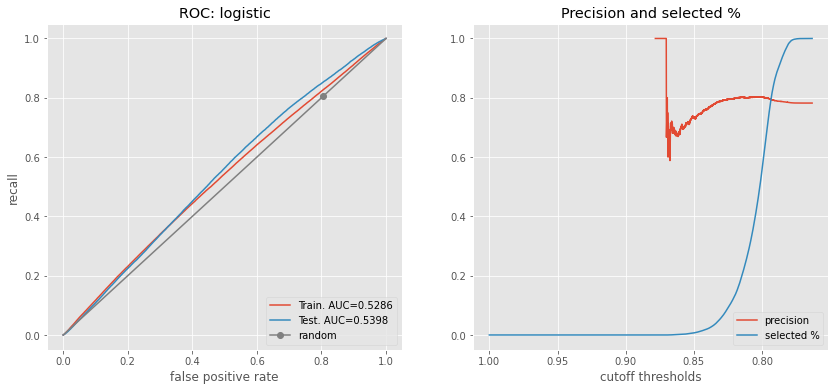

0.52856 0.53983 
{0.05: 0.7874238144789654, 0.1: 0.7951157863435305, 0.2: 0.8014532344687889, 1: 0.7821463088246227}
_credit_hist 	253 sec


KeyboardInterrupt: ignored

In [76]:
auc=[]
prec_20=[]
tic = time.time()

# computationally expensive, do not run by default
nn_fi = False

if nn_fi:

    for col in X_train.columns:

        X_train_shuffled = X_train.copy()

        for shuffle_col in X_train.columns:
            vals = X_train_shuffled[shuffle_col].values
            if shuffle_col!=col: np.random.shuffle(vals)
            X_train_shuffled[shuffle_col] = vals

        Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
            predict_probs(X_train_shuffled, X_test, Y_train, Y_test, 
                        'logistic',  #'neural network all', 
                        show_plot=True, 
                        verbose=0)
        auc.append(AUC_test)
        prec_20.append(precision[0.2])
        print(f'{col} \t{time.time()-tic:.0f} sec')
        print(60*'=')
    

In [ ]:
fi_report = pd.DataFrame({
'feature':X_train.columns,
'AUC_test':auc,
'P_20%':prec_20,
})
fi_report.sort_values(by='AUC_test', ascending=False)

In [ ]:
timestamp = int(time.time())
fi_report.to_csv(path+f'reports/importance_{timestamp}.csv')

## In-subgrade classification

In [102]:
# a general report dataframe structure:
df_template = pd.DataFrame(columns=['model',
                                  'run',
                                  'sec',
                                  'n_loans',
                                  'AUC_test',
                                  'prec_5',
                                  'prec_10',
                                  'prec_20',
                                  'support',
                                  'lift_5',
                                  'lift_10',
                                  'lift_20',

                                  ])
df_template

,model,run,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20


model trained in 5.6sec


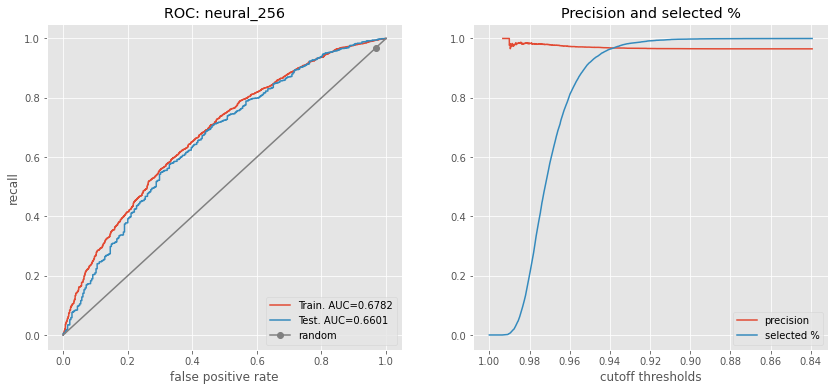

0.67821 0.66007 
{0.05: 0.9859154929577465, 0.1: 0.9827188940092166, 0.2: 0.9834221432800473, 1: 0.9649851632047478}
A1 	7.6 sec
model trained in 7.2sec


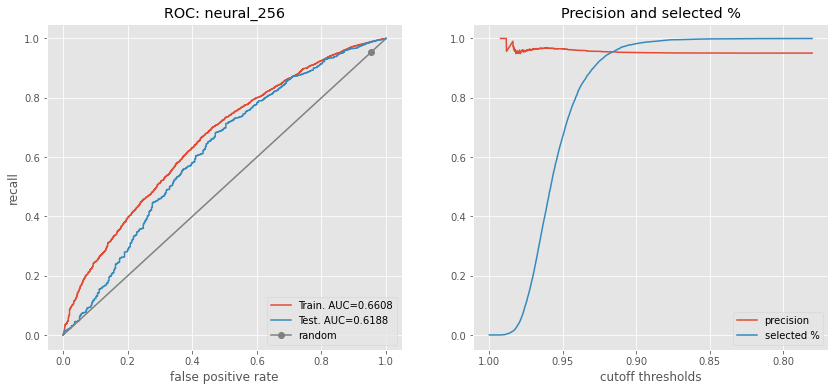

0.66081 0.61881 
{0.05: 0.9599198396793588, 0.1: 0.9577804583835947, 0.2: 0.9636699507389164, 1: 0.9506681653553141}
A2 	8.7 sec
model trained in 3.6sec


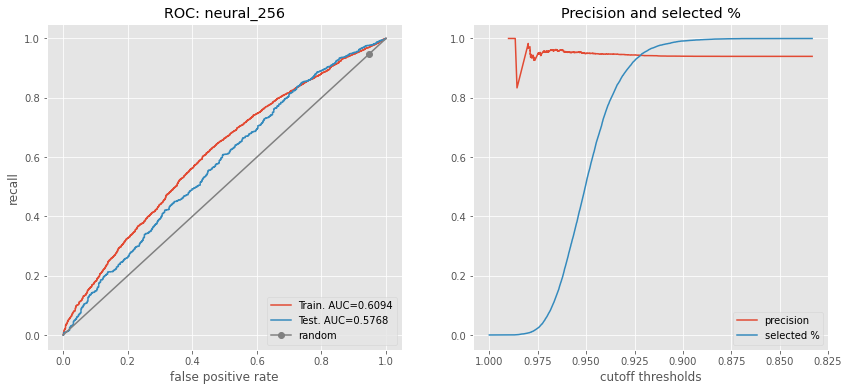

0.60945 0.57681 
{0.05: 0.9563218390804599, 0.1: 0.9619815668202766, 0.2: 0.9597871082199882, 1: 0.9396418830783826}
A3 	5.1 sec
model trained in 8.3sec


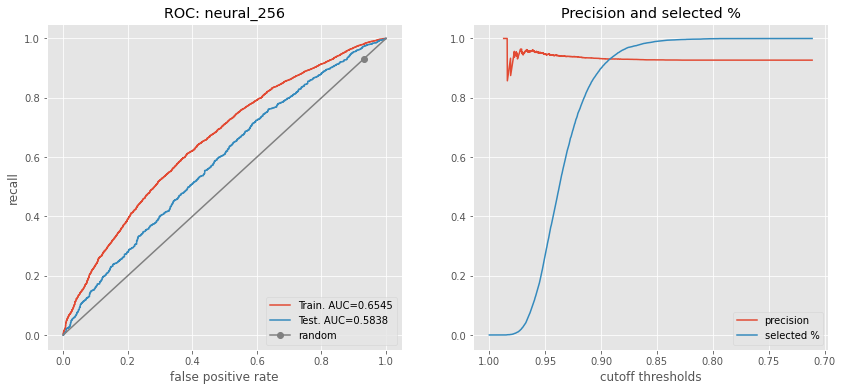

0.65450 0.58380 
{0.05: 0.9606126914660832, 0.1: 0.960427807486631, 0.2: 0.9516304347826088, 1: 0.9268561357127121}
A4 	10.4 sec
model trained in 5.3sec


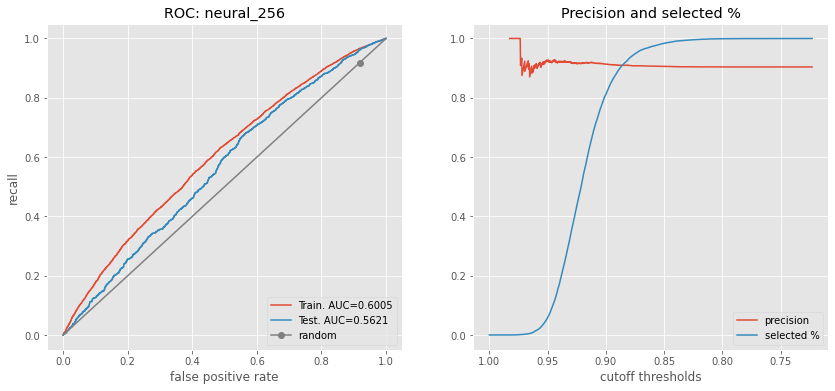

0.60054 0.56213 
{0.05: 0.9258589511754068, 0.1: 0.924476797088262, 0.2: 0.9217311233885819, 1: 0.9039658214915947}
A5 	7.6 sec
model trained in 11.8sec


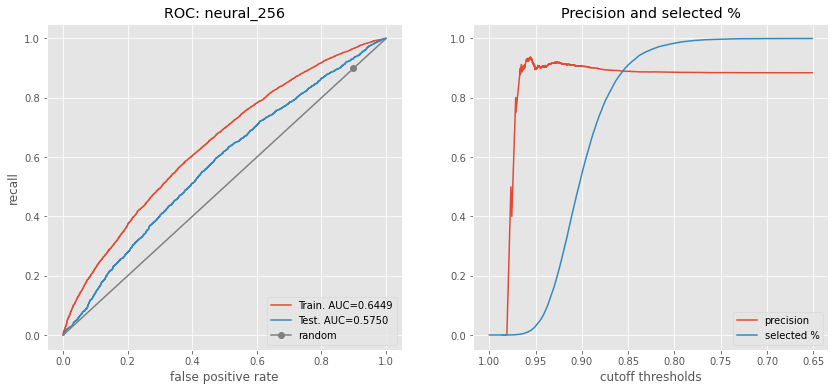

0.64491 0.57504 
{0.05: 0.9022164276401565, 0.1: 0.9100977198697069, 0.2: 0.9198957994138718, 1: 0.8843191017104061}
B1 	14.2 sec
model trained in 5.9sec


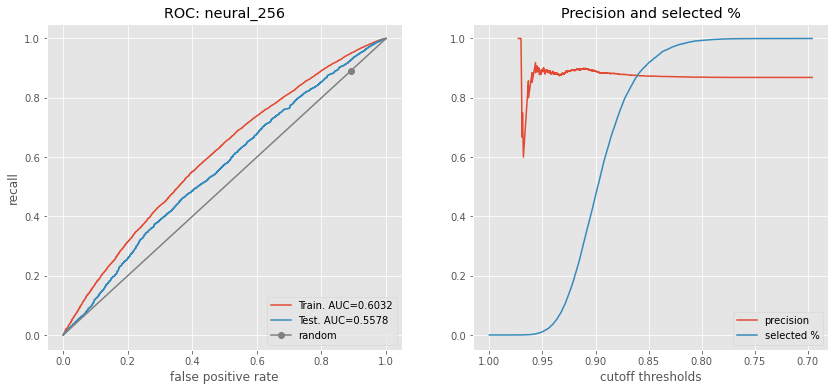

0.60315 0.55784 
{0.05: 0.8834080717488788, 0.1: 0.8820861678004536, 0.2: 0.8925869894099849, 1: 0.8685527912621359}
B2 	8.5 sec
model trained in 10.0sec


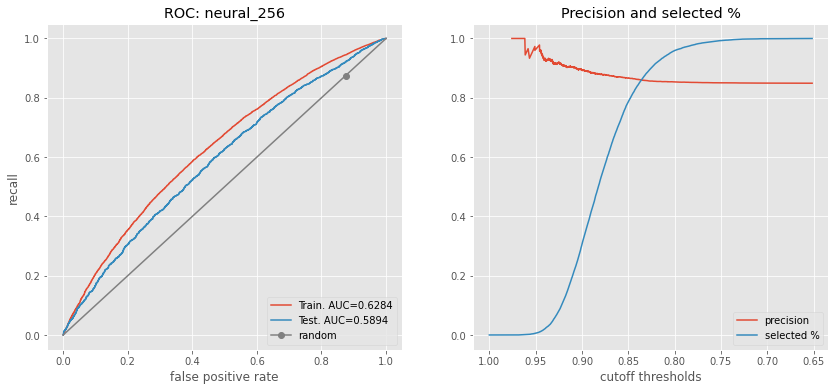

0.62842 0.58937 
{0.05: 0.9160530191458027, 0.1: 0.9120234604105573, 0.2: 0.9042553191489363, 1: 0.8490663517602776}
B3 	12.7 sec
model trained in 14.0sec


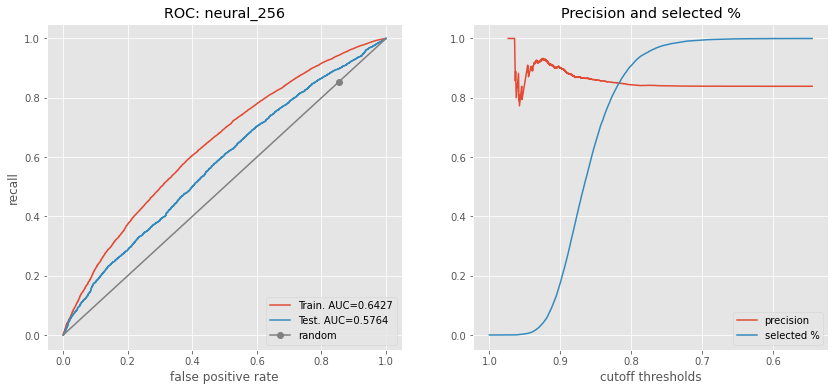

0.64270 0.57635 
{0.05: 0.9294436906377205, 0.1: 0.9100817438692098, 0.2: 0.8973747016706445, 1: 0.8387801050692502}
B4 	16.7 sec
model trained in 13.1sec


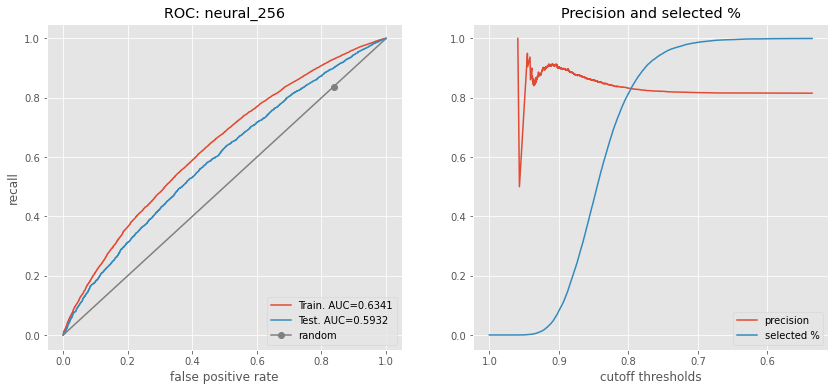

0.63415 0.59323 
{0.05: 0.9090909090909091, 0.1: 0.8981581798483207, 0.2: 0.8835004063939312, 1: 0.8154613466334164}
B5 	15.8 sec
model trained in 8.6sec


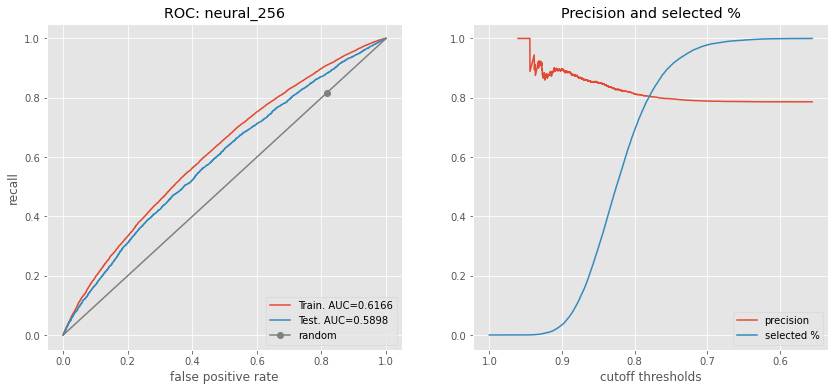

0.61663 0.58980 
{0.05: 0.8905579399141631, 0.1: 0.8742674480554075, 0.2: 0.8566058002148227, 1: 0.7864020224839976}
C1 	11.4 sec
model trained in 13.4sec


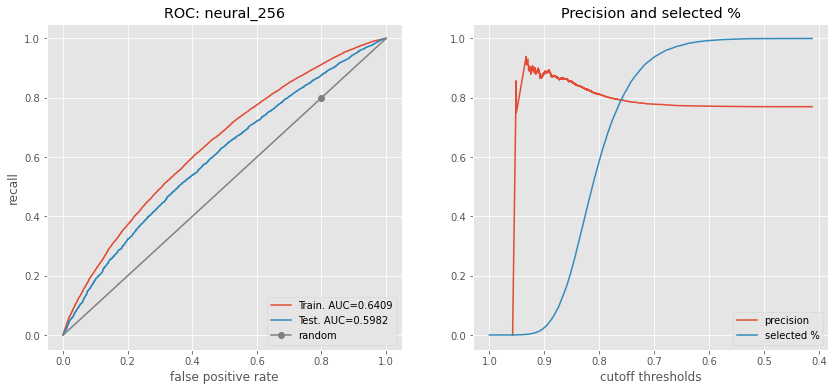

0.64091 0.59824 
{0.05: 0.8783783783783784, 0.1: 0.861145703611457, 0.2: 0.8573648228713487, 1: 0.7699065420560748}
C2 	16.0 sec
model trained in 9.2sec


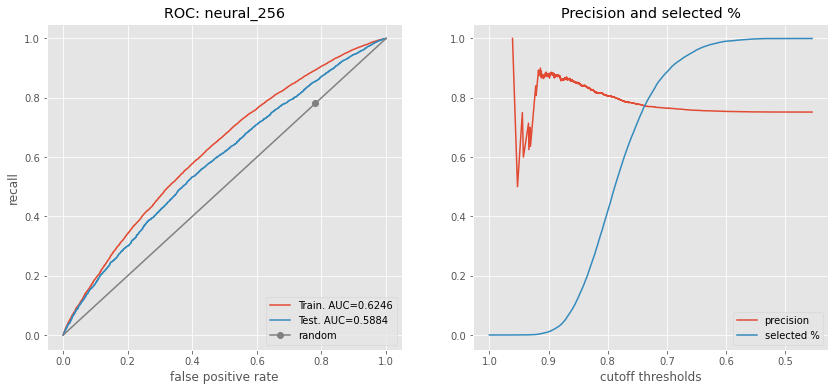

0.62464 0.58838 
{0.05: 0.8657465495608532, 0.1: 0.854033290653009, 0.2: 0.83472133247918, 1: 0.7517953321364452}
C3 	11.7 sec
model trained in 12.4sec


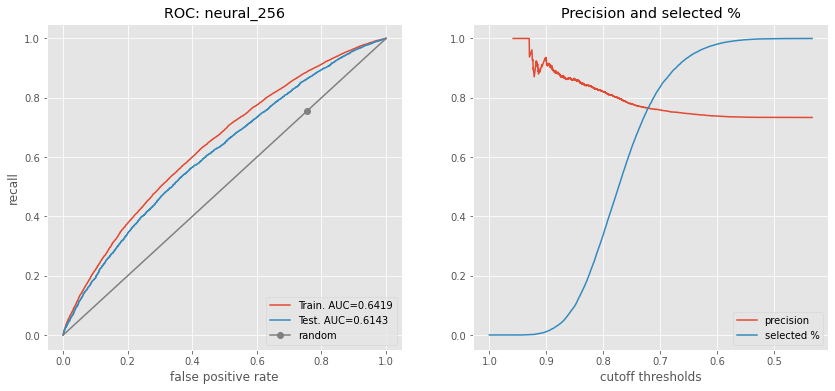

0.64192 0.61427 
{0.05: 0.8677884615384615, 0.1: 0.8595539481615431, 0.2: 0.8412650602409638, 1: 0.7335425089000182}
C4 	14.9 sec
model trained in 8.0sec


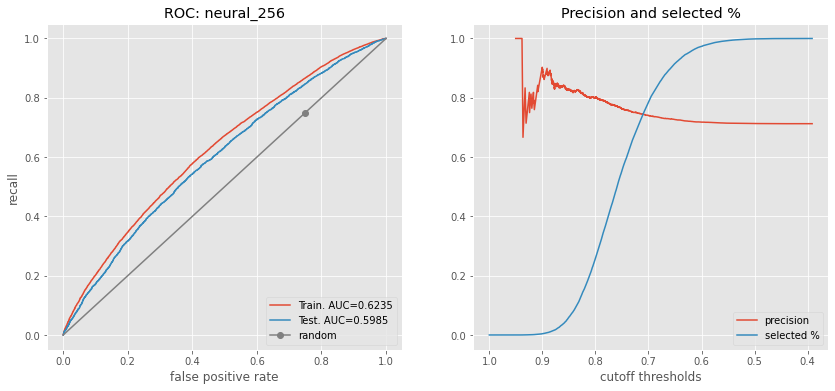

0.62347 0.59846 
{0.05: 0.8264840182648402, 0.1: 0.8256146369353917, 0.2: 0.8013757523645744, 1: 0.7126054277353836}
C5 	10.4 sec
model trained in 7.8sec


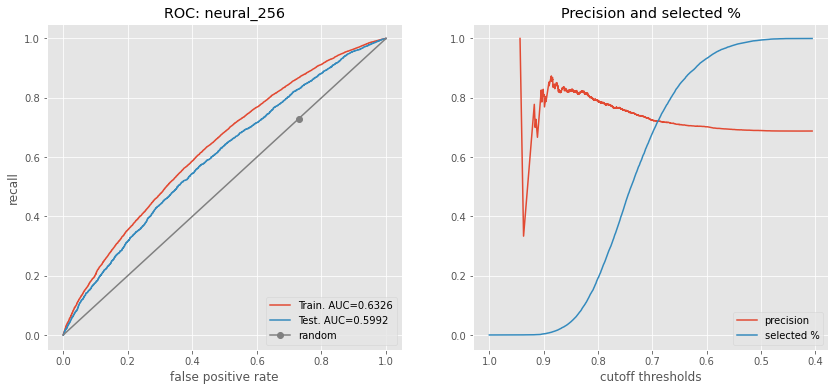

0.63263 0.59921 
{0.05: 0.8263598326359832, 0.1: 0.814931650893796, 0.2: 0.7867298578199052, 1: 0.6878490884181684}
D1 	9.7 sec
model trained in 9.1sec


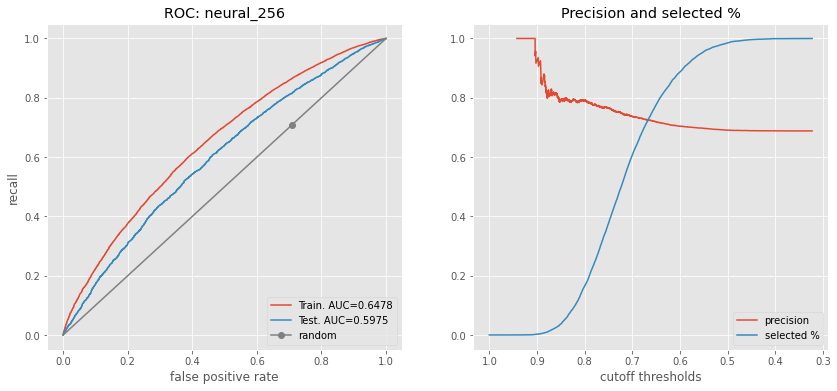

0.64782 0.59753 
{0.05: 0.7919999999999999, 0.1: 0.7905811623246493, 0.2: 0.7837837837837838, 1: 0.6882022471910112}
D2 	10.8 sec
model trained in 5.9sec


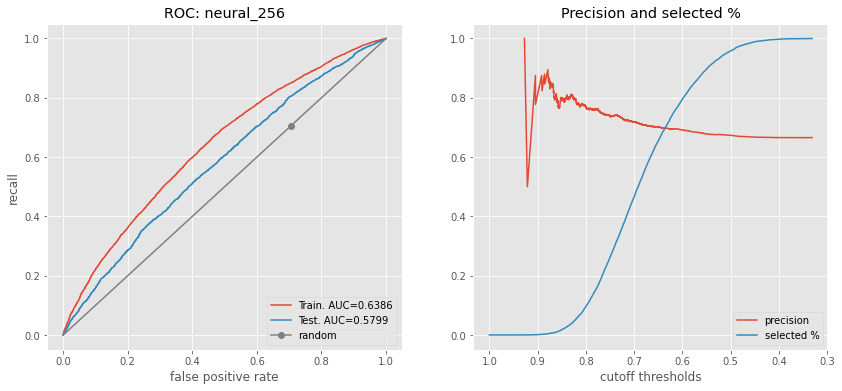

0.63860 0.57987 
{0.05: 0.7948717948717948, 0.1: 0.7655913978494624, 0.2: 0.7494623655913979, 1: 0.6655536406721241}
D3 	7.6 sec
model trained in 4.3sec


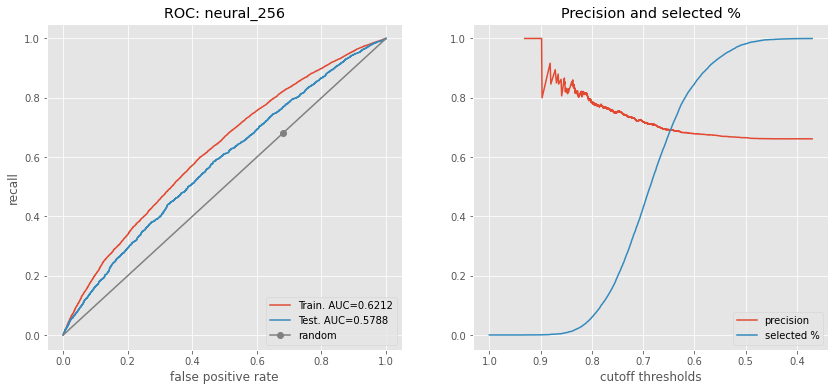

0.62118 0.57883 
{0.05: 0.7941176470588236, 0.1: 0.7725258493353029, 0.2: 0.7542687453600595, 1: 0.661511005353956}
D4 	5.8 sec
model trained in 7.2sec


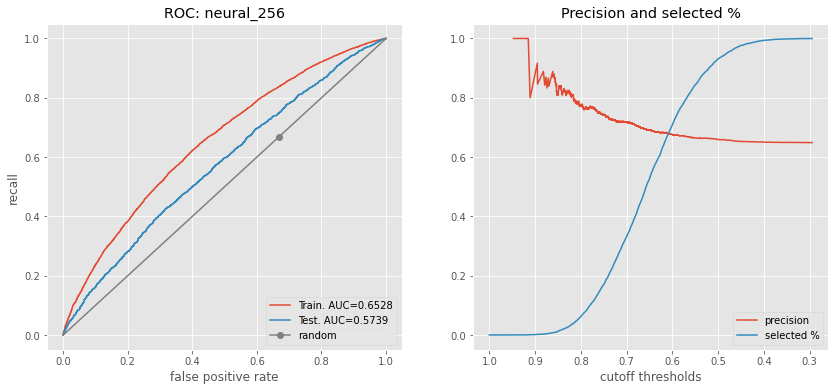

0.65278 0.57391 
{0.05: 0.7859531772575251, 0.1: 0.7688442211055276, 0.2: 0.7334450963956413, 1: 0.6487665715724115}
D5 	8.5 sec
model trained in 6.4sec


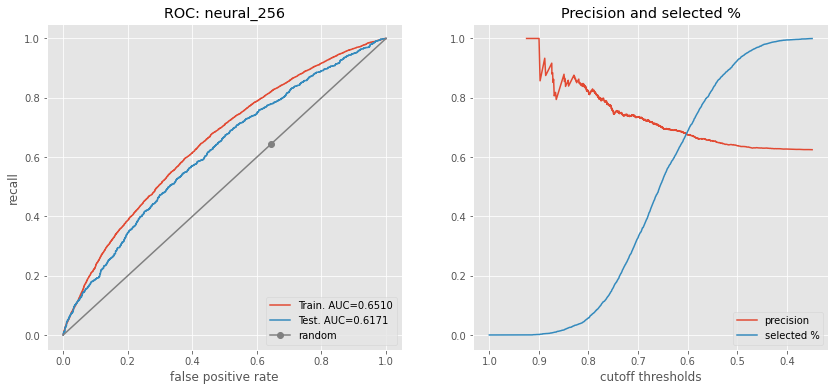

0.65103 0.61710 
{0.05: 0.8372093023255814, 0.1: 0.798219584569733, 0.2: 0.7488855869242199, 1: 0.6248883596308425}
E1 	7.6 sec
model trained in 6.5sec


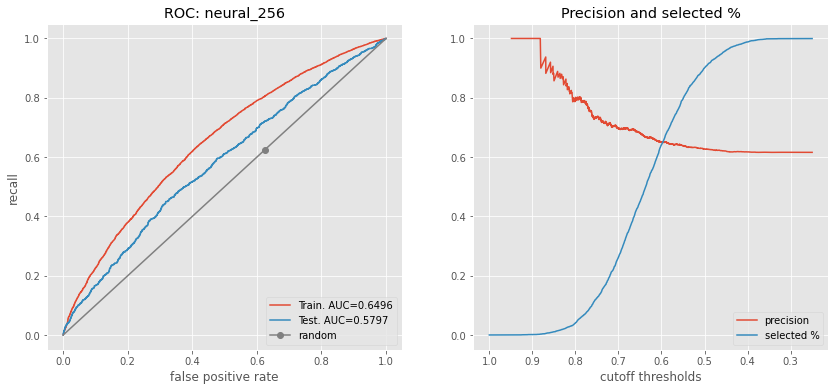

0.64962 0.57973 
{0.05: 0.8012422360248447, 0.1: 0.7444794952681387, 0.2: 0.7133757961783439, 1: 0.6159003831417624}
E2 	7.6 sec
model trained in 4.5sec


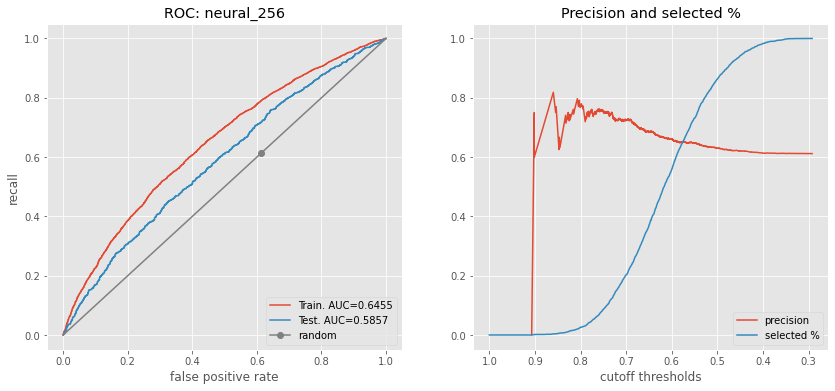

0.64548 0.58567 
{0.05: 0.7414965986394557, 0.1: 0.7534246575342466, 0.2: 0.7231833910034602, 1: 0.6115157821713493}
E3 	5.5 sec
model trained in 5.7sec


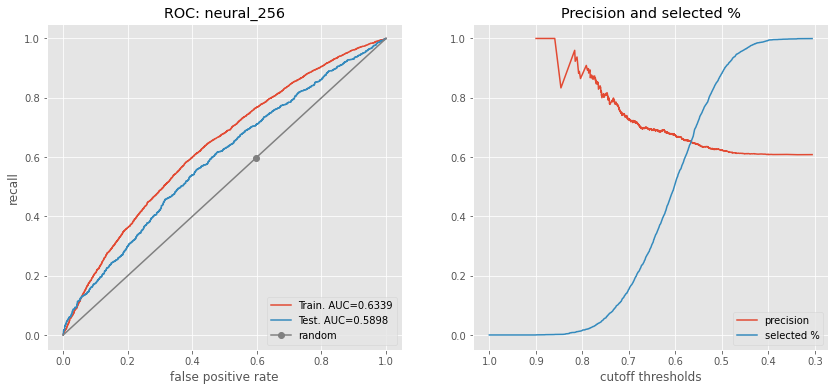

0.63394 0.58975 
{0.05: 0.8137931034482758, 0.1: 0.7793594306049821, 0.2: 0.7183600713012478, 1: 0.6082916368834882}
E4 	6.7 sec
model trained in 5.0sec


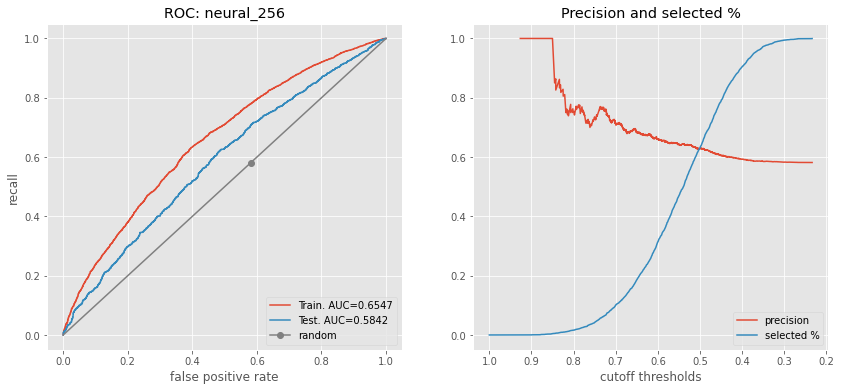

0.65474 0.58422 
{0.05: 0.763819095477387, 0.1: 0.7127371273712737, 0.2: 0.6829268292682926, 1: 0.5816798042946453}
E5 	5.9 sec


In [103]:
# CYCLE:
predictions = pd.DataFrame(columns=['_good','p'])
model_name = 'neural_256'
df_report = df_template.copy()

# for term in (0,1):
for sub_grade in range(1,26):

    tic = time.time()

    # X_train_s = X_train[X_train.term==term]
    # X_test_s = X_test[X_test.term==term]
    # Y_train_s = Y_train[X_train.term==term]
    # Y_test_s = Y_test[X_test.term==term]

    X_train_s = X_train[X_train.sub_grade==sub_grade]
    X_test_s = X_test[X_test.sub_grade==sub_grade]
    Y_train_s = Y_train[X_train.sub_grade==sub_grade]
    Y_test_s = Y_test[X_test.sub_grade==sub_grade]

    Y_test_s, Y_test_hat_s, AUC_train, AUC_test, precision =\
        predict_probs(X_train_s, X_test_s, Y_train_s, Y_test_s,
                    model_name, 
                    show_plot=True, 
                    verbose=0)

    Y_test_hat_s = pd.Series(np.squeeze(Y_test_hat_s), name='p', index=Y_test_s.index)
    grade_predictions = pd.concat([Y_test_s, Y_test_hat_s], axis=1)
    predictions = pd.concat([predictions, grade_predictions], axis=0)

    df_report.loc[df_report.shape[0]] = ([model_name] +
                                        # ['3 years' if term==0 else '5 years']+
                                         [sub_grades_dict_reverse[sub_grade]] +
                                         [f'{time.time()-tic:.1f}'] + 
                                         [f'{len(Y_test_s):,}'] +
                                         [np.round(AUC_test, 4)] +
                                         [np.round(x,4) for x in precision.values()] + 
                            [np.round(x/precision[1],4) for x in list(precision.values())[:-1]] 
                                        )
    print(f'{sub_grades_dict_reverse[sub_grade]} \t{time.time()-tic:.1f} sec')


In [104]:
Y_test_hat_s.head()

id
90218877    0.444949
90611316    0.489692
91483655    0.535288
91295586    0.333076
91050827    0.511280
Name: p, dtype: float32

In [105]:
timestamp = int(time.time())
filename = f'per_grade_predictions_{test_mode}_{timestamp}.csv'

predictions.index.rename('id', inplace=True)
predictions.to_csv(path+'features/'+filename)
predictions.shape
predictions.head()

,_good,p
id,,
90766973,1,0.971333
90747096,1,0.978240
90796273,1,0.973763
90681723,1,0.922008
89837324,1,0.978210


In [106]:
# save_report(df_report, test_mode)
df_report

,model,run,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20
0,neural_256,A1,7.6,"8,425",0.6601,0.9859,0.9827,0.9834,0.9650,1.0217,1.0184,1.0191
1,neural_256,A2,8.7,"8,007",0.6188,0.9599,0.9578,0.9637,0.9507,1.0097,1.0075,1.0137
2,neural_256,A3,5.1,"8,433",0.5768,0.9563,0.9620,0.9598,0.9396,1.0178,1.0238,1.0214
3,neural_256,A4,10.4,"9,078",0.5838,0.9606,0.9604,0.9516,0.9269,1.0364,1.0362,1.0267
4,neural_256,A5,7.6,"10,767",0.5621,0.9259,0.9245,0.9217,0.9040,1.0242,1.0227,1.0197
5,neural_256,B1,14.2,"15,318",0.5750,0.9022,0.9101,0.9199,0.8843,1.0202,1.0292,1.0402
6,neural_256,B2,8.5,"13,184",0.5578,0.8834,0.8821,0.8926,0.8686,1.0171,1.0156,1.0277
7,neural_256,B3,12.6,"13,549",0.5894,0.9161,0.9120,0.9043,0.8491,1.0789,1.0741,1.0650
8,neural_256,B4,16.7,"14,657",0.5764,0.9294,0.9101,0.8974,0.8388,1.1081,1.0850,1.0699
9,neural_256,B5,15.8,"18,446",0.5932,0.9091,0.8982,0.8835,0.8155,1.1148,1.1014,1.0834


### Lift per grade

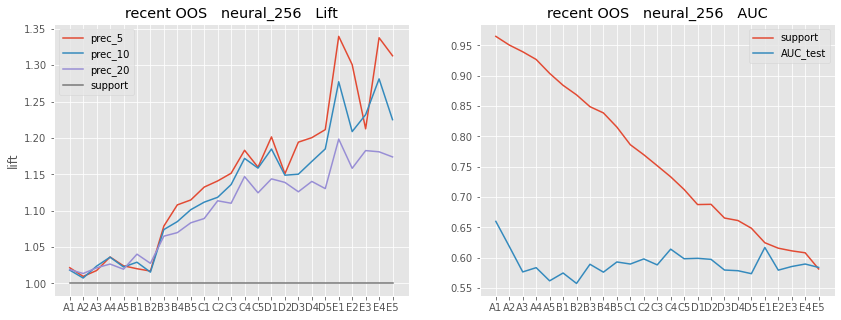

In [107]:
# Lift per grade - the lower the grade, the more the lift
plot_report_metrics(df_report, test_mode)

## In-subgrade feat.imp.

Within each subgrade, which features would help avoid defaulting loans?

In [122]:
# sub_grade=11
cols =  list(X_train.columns)
cols.remove('grade')
cols.remove('sub_grade')
cols.remove('term')

df_report = pd.DataFrame(columns=cols) 

for sub_grade in range(1,26):

    tic = time.time()

    X_train_s = X_train[(X_train.sub_grade==sub_grade) & (X_train.term==0)]
    X_test_s = X_test[(X_test.sub_grade==sub_grade) & (X_test.term==0)]
    Y_train_s = Y_train[(X_train.sub_grade==sub_grade) & (X_train.term==0)]
    Y_test_s = Y_test[(X_test.sub_grade==sub_grade) & (X_test.term==0)]

    X_train_s.drop(['grade', 'sub_grade', 'term'], axis=1, inplace=True)
    X_test_s.drop(['grade', 'sub_grade', 'term'], axis=1, inplace=True)

    model = LogisticRegression(penalty='l1', 
                                C=100, 
                                verbose=1,
                                solver='liblinear') # best HP from BD18
    model.fit(X_train_s, Y_train_s)

    Y_test_hat_s = model.predict_proba(X_test_s)[:,1]
    AUC_test_s = roc_auc_score(Y_test_s, Y_test_hat_s)

    # fi = list(zip(X_train_s.columns, model.coef_[0]))
    # fi.sort(key=lambda x:x[1], reverse=True) 

    x = model.coef_[0]
    ranks = [list(np.argsort(x)).index(list(x).index(i)) for i in x]
    df_report.loc[sub_grades_dict_reverse[sub_grade]] = ranks

    # df_report.loc[sub_grades_dict_reverse[sub_grade]] = model.coef_[0]
    #              [f'{time.time()-tic:.1f}'] + [AUC_test_s] + fi
    # print(fi)    
    print(f'{sub_grades_dict_reverse[sub_grade]} \t{time.time()-tic:.1f} sec')


[LibLinear]A1 	5.3 sec
[LibLinear]A2 	3.3 sec
[LibLinear]A3 	2.1 sec
[LibLinear]A4 	3.4 sec
[LibLinear]A5 	2.2 sec
[LibLinear]B1 	1.6 sec
[LibLinear]B2 	3.5 sec
[LibLinear]B3 	1.8 sec
[LibLinear]B4 	2.7 sec
[LibLinear]B5 	2.6 sec
[LibLinear]C1 	5.1 sec
[LibLinear]C2 	4.1 sec
[LibLinear]C3 	2.4 sec
[LibLinear]C4 	0.7 sec
[LibLinear]C5 	1.2 sec
[LibLinear]D1 	1.7 sec
[LibLinear]D2 	2.7 sec
[LibLinear]D3 	0.8 sec
[LibLinear]D4 	1.2 sec
[LibLinear]D5 	1.2 sec
[LibLinear]E1 	0.8 sec
[LibLinear]E2 	0.5 sec
[LibLinear]E3 	0.5 sec
[LibLinear]E4 	0.9 sec
[LibLinear]E5 	0.3 sec


In [123]:
df_report = df_report.apply(np.sum)
fi_subgrade = df_report.sort_values().reset_index()
fi_subgrade

,index,0
0,purpose_small_business,77
1,home_ownership_RENT,143
2,home_ownership_OWN,207
3,purpose_medical,230
4,verification_status,287
5,purpose_moving,296
6,purpose_renewable_energy,299
7,purpose_home_improvement,302
8,application_type,324
9,purpose_educational,332


In [124]:
fi_subgrade.to_csv(path+f'reports/in_grade_importance_1.csv')

In [125]:
fi_subgrade = pd.read_csv(path+f'reports/in_grade_importance_1.csv')
fi_subgrade.rename(columns={'0':'rank', 'index':'feature'}, inplace=True)
fi_subgrade.head()

,Unnamed: 0,feature,rank
0,0,purpose_small_business,77
1,1,home_ownership_RENT,143
2,2,home_ownership_OWN,207
3,3,purpose_medical,230
4,4,verification_status,287


In [126]:
fi_subgrade = fi_subgrade.sort_values('rank', ascending=True)
fi_subgrade[:2]

,Unnamed: 0,feature,rank
0,0,purpose_small_business,77
1,1,home_ownership_RENT,143


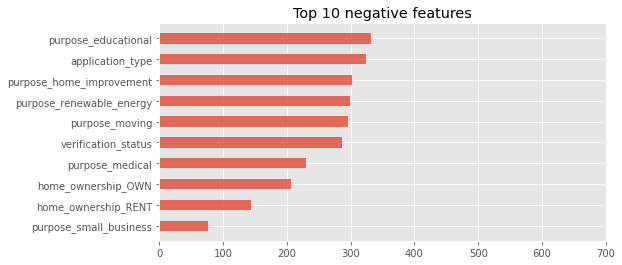

In [127]:
plt.figure(figsize=(8,4))
plt.barh(fi_subgrade.iloc[:10,1], fi_subgrade.iloc[:10,2], height=0.5, alpha=0.8)
plt.title('Top 10 negative features')
# plt.xlabel('importance rank')
plt.xlim([0,700])
plt.show()

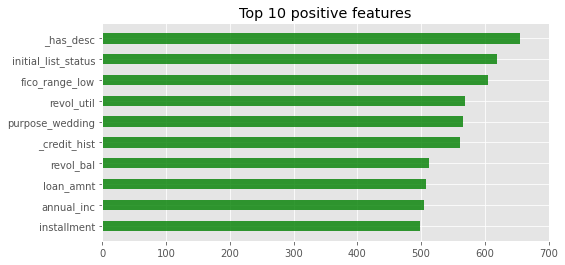

In [128]:
plt.figure(figsize=(8,4))
plt.barh(fi_subgrade.iloc[-10:,1], fi_subgrade.iloc[-10:,2], height=0.5, color='g', alpha=0.8)
plt.title('Top 10 positive features')
# plt.xlabel('importance rank')
plt.xlim([0,700])
plt.show()